<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/pixels_seg_ML_save_trained_model_1_multi_CLFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

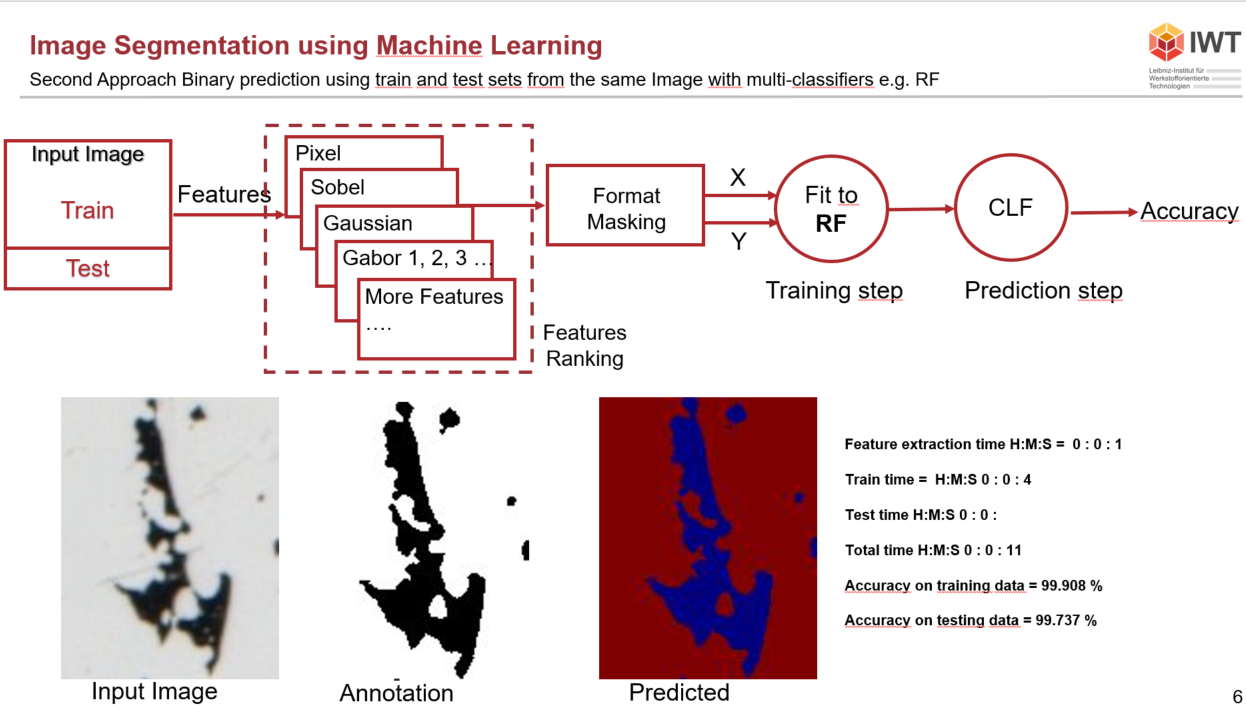

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear SVM  CLF: Feature extraction time = H:M:S 0 : 1 : 18
Linear SVM  CLF: Train time = H:M:S 0 : 0 : 18
Linear SVM  CLF: Test time = H:M:S 0 : 0 : 21
Linear SVM  CLF: Total time = H:M:S 0 : 1 : 58
Accuracy on training data =  99.947 %
Accuracy on testing data =  99.951 %
name RBF SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF SVM  CLF: Feature extraction time = H:M:S 0 : 1 : 18
RBF SVM  CLF: Train time = H:M:S 0 : 1 : 7
RBF SVM  CLF: Test time = H:M:S 0 : 1 : 33
RBF SVM  CLF: Total time = H:M:S 0 : 3 : 59
Accuracy on training data =  93.641 %
Accuracy on testing data =  93.629 %
name Decision Tree
Decision Tree  CLF: Feature extraction time = H:M:S 0 : 1 : 18
Decision Tree  CLF: Train time = H:M:S 0 : 3 : 19
Decision Tree  CLF: Test time = H:M:S 0 : 3 : 20
Decision Tree  CLF: Total time = H:M:S 0 : 7 : 58
Accuracy on training data =  100.0 %
Accuracy on testing data =  100.0 %
name Random Forest
Random Forest  CLF: Feature extraction time = H:M:S 0 : 1 : 18
Random Forest  CLF: Train time = H:M:S 0 : 4 : 10
Random Forest  CLF: Test time = H:M:S 0 : 4 : 16
Random Forest  CLF: Total time = H:M:S 0 : 9 : 45
Accuracy on training data =  99.923 %
Accuracy on testing data =  99.918 %
name Neural Net
Neural Net  CLF: Feature extraction time = H:M:S 0 : 1 : 18
Neural Net  CLF: Train time = H:M:S 0 : 10 : 32
Neur

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA  CLF: Feature extraction time = H:M:S 0 : 1 : 18
QDA  CLF: Train time = H:M:S 0 : 10 : 55
QDA  CLF: Test time = H:M:S 0 : 10 : 57
QDA  CLF: Total time = H:M:S 0 : 23 : 11
Accuracy on training data =  98.903 %
Accuracy on testing data =  98.895 %


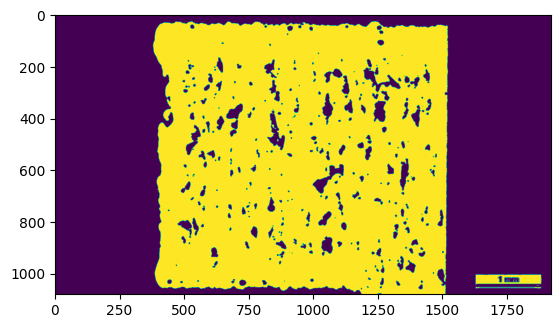

In [ ]:

from skimage.io import imread, imshow
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time

#img = cv2.imread('BSE_Image.jpg')
img = cv2.imread('/content/001.JPG')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 
#Multiple images can be used for training. For that, you need to concatenate the data

#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()

t0 = time.time()   ## starting time

df['Original Image'] = img2

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
########################################
#Gerate OTHER FEATURES out of pixels and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe

feat_ext_time = time.time()-t0
local_time_feature_rxtraction = time.localtime(feat_ext_time)
###########################               

#Now, add a column in the data frame for the Labels
#For this, we need to import the labeled image
# labeled_img = cv2.imread('/content/Sandstone_Versa0000(mask).tif')  # if we use saved mask
 ########################## if we do not use ready saved mask
ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY) ## I will assume our mask is the binary image
#imshow(binary.reshape(img.shape))

plt.imshow(binary, cmap ='jet')
labeled_img =binary
############################
#Remember that you can load an image with partial labels 
#But, drop the rows with unlabeled data

#labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY) # if we use mask
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

print('the unique labels', df['Labels'].unique())
print('the count of the unique labels', df['Labels'].value_counts())
# df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
print(df.head())

df.to_csv("pixels_features_and_lables.csv")
#############################
#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)
############################### list of classifieres:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# names = ["Nearest Neighbors", "Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
# ##,"Gaussian Process"
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]
## , random_state=42


names = ["Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
##,"Gaussian Process"
classifiers = [
    SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
    SVC(gamma=2, C=1, max_iter=100, random_state=42),
    #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
    DecisionTreeClassifier(max_depth=5, random_state = 42),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
    MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

############################### 
# Import the model we are using RandomForestRegressor 

start_train_time = time.time()
for name, model in zip(names, classifiers):
  print('name', name)
  # Train the model on training data
  model.fit(X_train, y_train)
  train_time = time.time()-start_train_time
  local_train_time = time.localtime(train_time)

  # verify number of trees used. If not defined above. 
  #print('Number of Trees used : ', model.n_estimators)

  #STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA AND CALCULATE THE ACCURACY SCORE
  #First test prediction on the training data itself. SHould be good. 
  prediction_test_train = model.predict(X_train)
  start_test_time = time.time()-train_time

  #Test prediction on testing data. 
  prediction_test = model.predict(X_test)

  test_time = time.time()-start_test_time
  local_test_time = time.localtime(test_time)
  print(name, ' CLF: Feature extraction time = H:M:S', local_time_feature_rxtraction.tm_hour,':',local_time_feature_rxtraction.tm_min,':',local_time_feature_rxtraction.tm_sec)
  print(name, ' CLF: Train time = H:M:S', local_train_time.tm_hour,':',local_train_time.tm_min,':',local_train_time.tm_sec)
  print(name, ' CLF: Test time = H:M:S', local_test_time.tm_hour,':',local_test_time.tm_min,':',local_test_time.tm_sec)
  total_time = feat_ext_time+train_time+test_time
  total_time = time.localtime(total_time)
  print(name, ' CLF: Total time = H:M:S', total_time.tm_hour,':',total_time.tm_min,':',total_time.tm_sec)

  #.predict just takes the .predict_proba output and changes everything to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
  #In this example we have 2 labels, so the probabilities will for each label stored separately. 

  #prediction_prob_test = model.predict_proba(X_test)

  #Let us check the accuracy on test data
  from sklearn import metrics
  #Print the prediction accuracy

  #First check the accuracy on training data. This will be higher than test data prediction accuracy.
  train_acc = metrics.accuracy_score(y_train, prediction_test_train)*100
  print ("Accuracy on training data = ", round(train_acc,3), '%')
  #Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
  test_acc = metrics.accuracy_score(y_test, prediction_test)*100
  print ("Accuracy on testing data = ", round(test_acc,3), '%')

  #This part commented out for SVM testing. Uncomment for random forest. 
  #One amazing feature of Random forest is that it provides us info on feature importances
  # Get numerical feature importances importances = list(model.feature_importances_)

  # feature_list = list(X.columns)
  # feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
  # print('The scors or important features',feature_imp)
  # feature_imp.to_csv("important_features.csv")

  #You can store the model for future use. In fact, this is how you do machine elarning
  #Train on training images, validate on test images and deploy the model on unknown images. 

  import pickle

  #Save the trained model as pickle string to disk for future use
  filename = "/content/CLF_res/{}_trained_model".format(name)

  pickle.dump(model, open(filename, 'wb'))

  #To test the model on future datasets
  loaded_model = pickle.load(open(filename, 'rb'))
  result = loaded_model.predict(X)

  segmented = result.reshape((img.shape))

  plt.imshow(segmented)
  plt.imsave('/content/CLF_res/predicted_image_{}.jpg'.format(name), segmented)

In [ ]:
from google.colab import files
!zip -r /content/CLF_res.zip /content/CLF_res
files.download('/content/CLF_res.zip')

  adding: content/CLF_res/ (stored 0%)
  adding: content/CLF_res/predicted_image_Neural Net.jpg (deflated 19%)
  adding: content/CLF_res/AdaBoost_trained_model (deflated 62%)
  adding: content/CLF_res/Decision Tree_trained_model (deflated 51%)
  adding: content/CLF_res/predicted_image_Decision Tree.jpg (deflated 18%)
  adding: content/CLF_res/predicted_image_RBF SVM.jpg (deflated 38%)
  adding: content/CLF_res/predicted_image_Naive Bayes.jpg (deflated 19%)
  adding: content/CLF_res/predicted_image_Random Forest.jpg (deflated 19%)
  adding: content/CLF_res/Random Forest_trained_model (deflated 70%)
  adding: content/CLF_res/predicted_image_QDA.jpg (deflated 19%)
  adding: content/CLF_res/predicted_image_AdaBoost.jpg (deflated 18%)
  adding: content/CLF_res/Naive Bayes_trained_model (deflated 38%)
  adding: content/CLF_res/Neural Net_trained_model (deflated 4%)
  adding: content/CLF_res/QDA_trained_model (deflated 33%)
  adding: content/CLF_res/RBF SVM_trained_model (deflated 83%)
  addi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##rm -rf '/content/CLF_res' ## dengarous will delete all the folder 

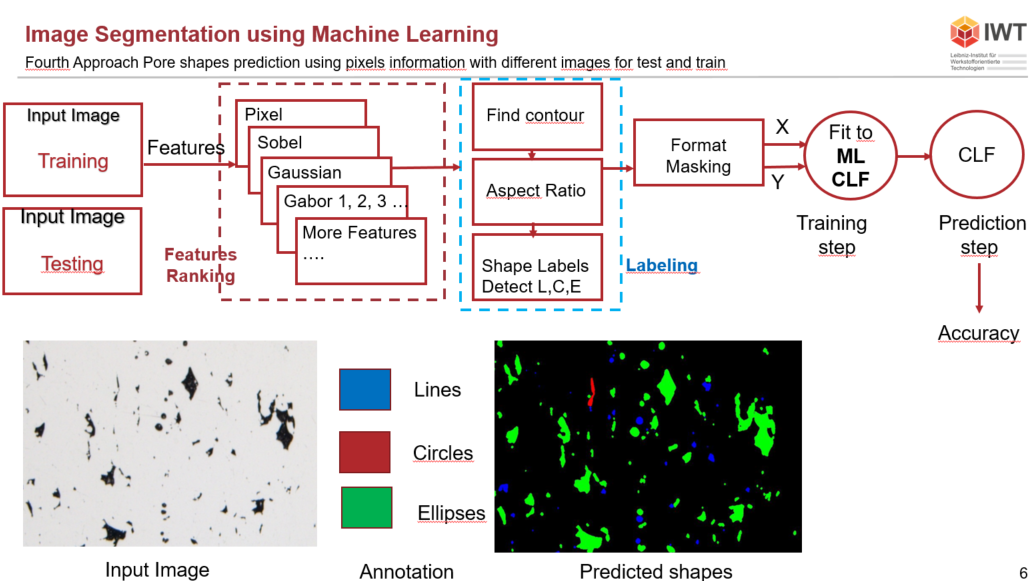

# **New approach to use 3 labels of shapes instaed of binary**

orginal image
img.shape (12, 12, 3)


gray image
gray image.shape (12, 12)


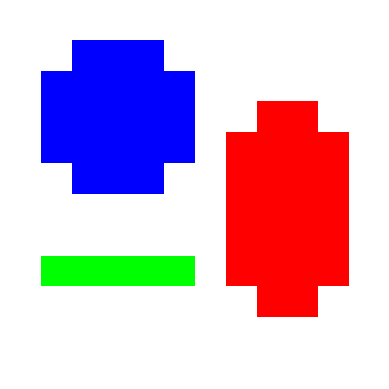

In [26]:
## load the training image
from skimage.io import imread, imshow
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow

img_org = cv2.imread('/content/small_image.png')
#img_org = img_org[:, 300:1600]  ## croped image
print('orginal image')
print('img.shape',img_org.shape)
cv2_imshow(img_org)

img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY) 
print('gray image')
print('gray image.shape',img.shape)
cv2_imshow(img)

plt.imshow(img_org)
plt.axis('off')
plt.show()

# Extract pixel features

In [27]:
#Here, if we have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 
#Multiple images can be used for training. For that, we need to concatenate the data
#Save original image pixels into a data frame. This is our Feature #1.

img2 = img.reshape(-1) ## reshape the image into single column
print('img2.shape',img2.shape)
df = pd.DataFrame()
t0 = time.time()   ## starting time

df['Original Image'] = img2

# #Generate Gabor features
# num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
# kernels = []
# for theta in range(2):   #Define number of thetas
#     theta = theta / 4. * np.pi
#     for sigma in (1, 3):  #Sigma with 1 and 3
#         for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
#             for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
#                 gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
# #                print(gabor_label)
#                 ksize=3  # we can use 9 if the image big size
#                 kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
#                 kernels.append(kernel)
#                 #Now filter the image and add values to a new column 
#                 fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
#                 filtered_img = fimg.reshape(-1)
#                 df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
#                 print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
#                 num += 1  #Increment for gabor column label
                
########################################
#Gerate OTHER FEATURES out of pixels and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe

feat_ext_time = time.time()-t0
local_time_feature_rxtraction = time.localtime(feat_ext_time)

img2.shape (144,)


img.shape (12, 12)
img2.shape (144,)


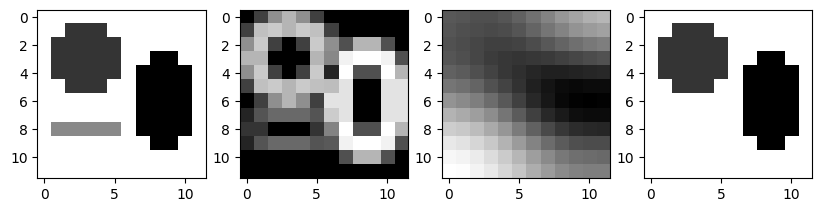

In [ ]:
# show some pf the feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(10,10))
print('img.shape',img.shape)
print('img2.shape',img2.shape)

axes[0].imshow(np.asanyarray(df['Original Image']).reshape(img.shape), cmap=plt.cm.gray)
axes[1].imshow(np.asanyarray(df['Sobel']).reshape(img.shape), cmap=plt.cm.gray)
axes[2].imshow(np.asanyarray(df['Gaussian s3']).reshape(img.shape), cmap=plt.cm.gray)
axes[3].imshow(np.asanyarray(df['Median s3']).reshape(img.shape), cmap=plt.cm.gray)


# output (pore shapes) labels and create a mask

the binary image
binary shape (12, 12)


len main contours 4
aspect ratio 3.0
aspect ratio 1.6
aspect ratio 1.0
the annotated image
annotated_img shape (12, 12, 3)


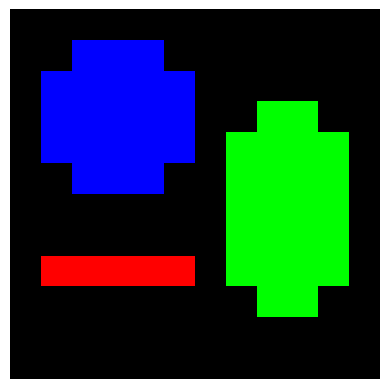

In [28]:
# Threshold the image to obtain binary image
ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print('len main contours', len(contours))
max_cnt = max(contours, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]

# Loop through each contour
for i, cnt in enumerate(contours):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 3:
            annotation = 1 # (1) Label as a line
        elif aspect_ratio > 1.0 and aspect_ratio < 3:
            annotation = 3 # (3) Label as an ellipse 
        else:
            annotation = 2 # (2) Label as a circle
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation, -1)
        cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour line to be drawn

# Combine all masks to create the final annotation image
annotation = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation[mask > 0] = mask[mask > 0]

# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img = np.zeros_like(img_org)

for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation == annotation_value)
  for x,y in pixels_of_certain_type:
    annotated_img[x, y] = np.array(color)


# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img.shape)
#cv2_imshow(annotated_img)
plt.imsave('/content/annotated_img.jpg', annotated_img)


plt.imshow(annotated_img)
plt.axis('off')
plt.show()

# Add the labels variable then save the features and labels into csv file

In [29]:

labeled_img1 = annotation.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)
print('annotation shape', annotation.shape)

df['Labels'] = labeled_img1
#####################################
print('the unique labels', df['Labels'].unique())
print('the count of the unique labels', df['Labels'].value_counts())

#print("labeled_img1", labeled_img1[88600:88829])
#df.to_csv("before_removing_pixels_pixels_features_and_lables.csv")
#df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
###print(df.head())
df.to_csv("pixels_features_and_lables.csv")

labeled_img1 shape (144,)
annotation shape (12, 12)
the unique labels [0 2 3 1]
the count of the unique labels 0    94
3    24
2    21
1     5
Name: Labels, dtype: int64


# Define the dependent variable that needs to be predicted (labels) and split into train and test

# Train model with 60% of the image data

In [ ]:

# Y = df["Labels"].values
# #Define the independent variables
# X = df.drop(labels = ["Labels"], axis=1) 

# #Split data into train and test to verify accuracy after fitting the model. 
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

# Train model with all the image data

In [30]:
Y = df["Labels"].values
#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

# import the classifiers

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# names = ["Nearest Neighbors", "Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
# ##,"Gaussian Process"
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]
## , random_state=42

# names = ["Linear_SVM","RBF_SVM","Decision_Tree","Random_Forest","Neural_Net","Naive_Bayes"]
# ##,"Gaussian Process"
# classifiers = [
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=10, n_estimators=200, max_features=5, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     GaussianNB(),
# ]

names = ["Random Forest"]
##,"Gaussian Process"
classifiers = [
    RandomForestClassifier(max_depth=10, n_estimators=200, max_features=5, random_state = 42)
]

# Train model with 60% of the image data

In [ ]:
# start_train_time = time.time()
# for name, model in zip(names, classifiers):
#   print('name', name)
#   # Train the model on training data
#   model.fit(X_train, y_train)
#   train_time = time.time()-start_train_time
#   local_train_time = time.localtime(train_time)

#   # verify number of trees used. If not defined above. 
#   #print('Number of Trees used : ', model.n_estimators)

#   #STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA AND CALCULATE THE ACCURACY SCORE
#   #First test prediction on the training data itself. SHould be good. 
#   prediction_train = model.predict(X_train)
#   start_test_time = time.time()-train_time
#   print("prediction_train results", prediction_train[:250])

#   #Test prediction on testing data. 
#   prediction_test = model.predict(X_test)
#   print("prediction_test results", prediction_test[:250])
#   print('X_train.shape',X_train.shape)
#   print('X_test.shape',X_test.shape)
#   print('prediction_train.shape',prediction_train.shape)
#   print('prediction_test.shape',prediction_test.shape)
#   print('img.shape',img.shape)
#   concat_train_test = np.concatenate((prediction_train, prediction_test), axis=0)
#   print('concat_train_test',concat_train_test.shape)
#   print('type of prediction_train', type(prediction_train))
#   # plt.imshow(concat_train_test.reshape(img.shape))
#   # cv2_imshow(concat_train_test.reshape(img.shape))
#   ##plt.imshow(concat_train_test.reshape(img.shape), vmin=0, vmax=2)

#   test_time = time.time()-start_test_time
#   local_test_time = time.localtime(test_time)
#   print(name, ' CLF: Feature extraction time = H:M:S', local_time_feature_rxtraction.tm_hour,':',local_time_feature_rxtraction.tm_min,':',local_time_feature_rxtraction.tm_sec)
#   print(name, ' CLF: Train time = H:M:S', local_train_time.tm_hour,':',local_train_time.tm_min,':',local_train_time.tm_sec)
#   print(name, ' CLF: Test time = H:M:S', local_test_time.tm_hour,':',local_test_time.tm_min,':',local_test_time.tm_sec)
#   total_time = feat_ext_time+train_time+test_time
#   total_time = time.localtime(total_time)
#   print(name, ' CLF: Total time = H:M:S', total_time.tm_hour,':',total_time.tm_min,':',total_time.tm_sec)

#   #.predict just takes the .predict_proba output and changes everything to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
#   #In this example we have 2 labels, so the probabilities will for each label stored separately. 

#   #prediction_prob_test = model.predict_proba(X_test)

#   #Let us check the accuracy on test data
#   from sklearn import metrics

#   #First check the accuracy on training data. This will be higher than test data prediction accuracy.
#   train_acc = metrics.accuracy_score(y_train, prediction_train)*100
#   print ("Accuracy on training data = ", round(train_acc,3), '%')
#   #Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
#   test_acc = metrics.accuracy_score(y_test, prediction_test)*100
#   print ("Accuracy on testing data = ", round(test_acc,3), '%')

#   #This part commented out for SVM testing. Uncomment for random forest. 
#   #One amazing feature of Random forest is that it provides us info on feature importances
#   #Get numerical feature importances importances = list(model.feature_importances_)

#   # feature_list = list(X.columns)
#   # feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
#   # print('The scors or important features',feature_imp)
#   # feature_imp.to_csv("important_features.csv")

#   #Store the model for future use. In fact, this is how you do machine elarning
#   #Train on training images, validate on test images and deploy the model on unknown images. 

#   import pickle
#   #Save the trained model as pickle string to disk for future use
#   filename = "/content/CLF_res/{}_trained".format(name)
#   pickle.dump(model, open(filename, 'wb'))


name Random Forest
prediction_train results [1 0 0 0 0 2 1 2 3 0 2 3 2 2 0 3 0 0 0 3 3 3 0 0 3 2 2 2 0 2 3 3 1 2 1 3 3
 3 2 3 2 3 3 2 0 0 3 3 3 1 0 3 2 0 0 0 0 0 3 0 3 1 3 3 3 0 2 0 2 2 2 0 0 0
 1 3 2 2 2 3 3 0 2 0 2 1]
prediction_test results [1 0 3 3 0 3 3 2 2 0 0 0 3 0 0 0 3 0 0 2 0 2 0 2 0 3 0 2 1 0 1 0 2 2 1 3 1
 3 2 0 2 2 0 0 3 3 3 2 2 0 1 0 2 3 0 1 0 0]
X_train.shape (86, 10)
X_test.shape (58, 10)
prediction_train.shape (86,)
prediction_test.shape (58,)
img.shape (12, 12)
concat_train_test (144,)
type of prediction_train <class 'numpy.ndarray'>
Random Forest  CLF: Feature extraction time = H:M:S 0 : 0 : 1
Random Forest  CLF: Train time = H:M:S 0 : 0 : 0
Random Forest  CLF: Test time = H:M:S 0 : 0 : 0
Random Forest  CLF: Total time = H:M:S 0 : 0 : 2
Accuracy on training data =  100.0 %
Accuracy on testing data =  94.828 %


# Train model with all the image data

In [32]:
start_train_time = time.time()
for name, model in zip(names, classifiers):
  print('name', name)
  # Train the model on training data
  model.fit(X, Y)
  train_time = time.time()-start_train_time
  local_train_time = time.localtime(train_time)

  # verify number of trees used. If not defined above. 
  #print('Number of Trees used : ', model.n_estimators)

  #STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA AND CALCULATE THE ACCURACY SCORE
  #First test prediction on the training data itself. SHould be good. 
  prediction_train = model.predict(X)
  print("prediction_train results", prediction_train[:250])
  print('X_train.shape',X.shape)
  print('prediction_train.shape',prediction_train.shape)
  print('img.shape',img.shape)
  print('type of prediction_train', type(prediction_train))

  print(name, ' CLF: Feature extraction time = H:M:S', local_time_feature_rxtraction.tm_hour,':',local_time_feature_rxtraction.tm_min,':',local_time_feature_rxtraction.tm_sec)
  print(name, ' CLF: Train time = H:M:S', local_train_time.tm_hour,':',local_train_time.tm_min,':',local_train_time.tm_sec)

  total_time = feat_ext_time+train_time
  total_time = time.localtime(total_time)
  print(name, ' CLF: Total time = H:M:S', total_time.tm_hour,':',total_time.tm_min,':',total_time.tm_sec)

  #prediction_prob_test = model.predict_proba(X_test)

  #Let us check the accuracy on test data
  from sklearn import metrics

  #First check the accuracy on training data. This will be higher than test data prediction accuracy.
  train_acc = metrics.accuracy_score(Y, prediction_train)*100
  print ("Accuracy on training data = ", round(train_acc,3), '%')

  #This part commented out for SVM testing. Uncomment for random forest. 
  #One amazing feature of Random forest is that it provides us info on feature importances
  #Get numerical feature importances importances = list(model.feature_importances_)

  # feature_list = list(X.columns)
  # feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
  # print('The scors or important features',feature_imp)
  # feature_imp.to_csv("important_features.csv") 

  import pickle
  #Save the trained model as pickle string to disk for future use
  filename = "/content/CLF_res/{}_trained".format(name)
  pickle.dump(model, open(filename, 'wb'))

name Random Forest
prediction_train results [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 3 3 0 0 0 2 2 2 2 2 0 3 3 3 3 0 0 0 2 2 2 0 0 3 3 3 3 0 0 0
 0 0 0 0 0 3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3 0 0 1 1 1 1 1 0 3 3 3 3 0 0 0 0
 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
X_train.shape (144, 10)
prediction_train.shape (144,)
img.shape (12, 12)
type of prediction_train <class 'numpy.ndarray'>
Random Forest  CLF: Feature extraction time = H:M:S 0 : 0 : 0
Random Forest  CLF: Train time = H:M:S 0 : 0 : 0
Random Forest  CLF: Total time = H:M:S 0 : 0 : 0
Accuracy on training data =  100.0 %


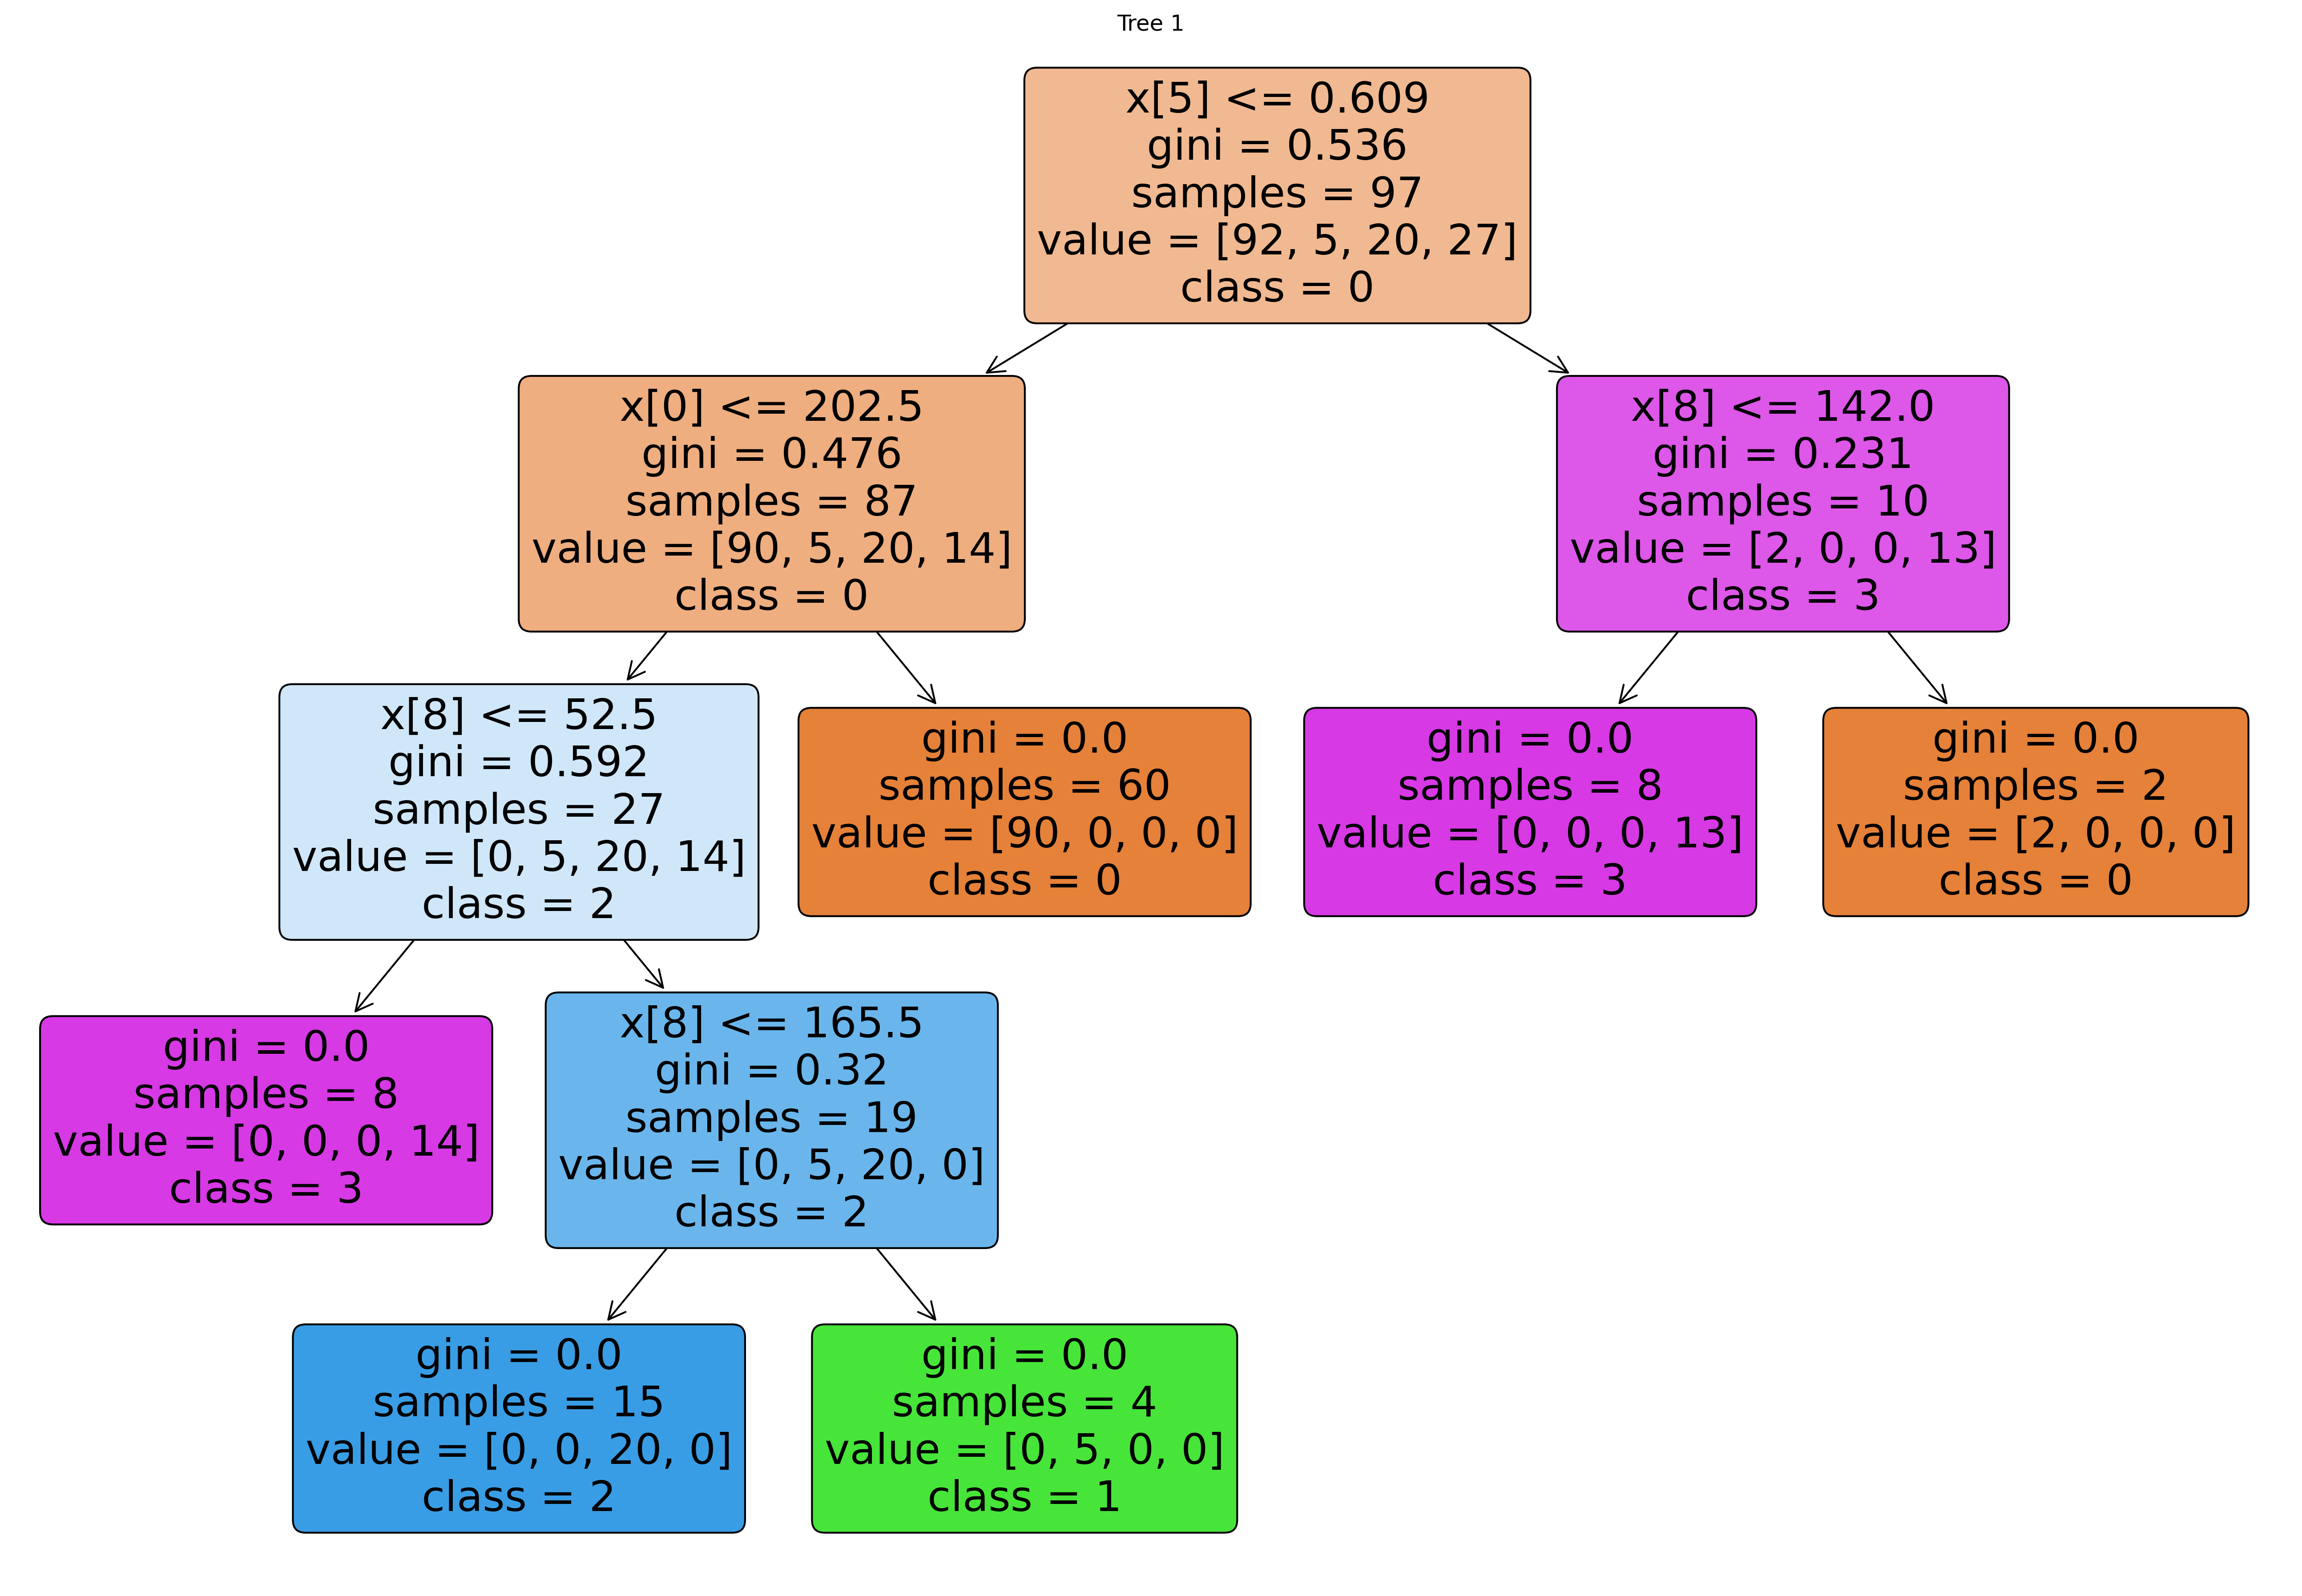

In [33]:

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
# Select the index of the tree you want to plot (e.g., 3rd tree)
tree_index = 0

# Plot the selected tree
plt.figure(figsize=(22, 15), dpi=300)
tree.plot_tree(model.estimators_[tree_index], filled=True, rounded=True, class_names=['0','1','2','3'])
plt.title(f'Tree {tree_index+1}')
plt.xlabel('Features')
plt.ylabel('Classes')

# Save the plot to an image file
plt.savefig('/content/predicted_images/RF_tree_image.png')
plt.show()

# **Predict using new images with the saved models**

orginal image
img.shape (12, 12, 3)


gray image
gray image.shape (12, 12)


img2.shape (144,)
img.shape (12, 12)
img2.shape (144,)
the binary image
binary shape (12, 12)


len main contours 3
the annotated image
annotated_img shape (12, 12, 3)
labeled_img1 shape (144,)
annotation shape (12, 12)
the unique labels [0 3 2]
the count of the unique labels 0    99
3    24
2    21
Name: Labels, dtype: int64
df after remove background (144, 11)


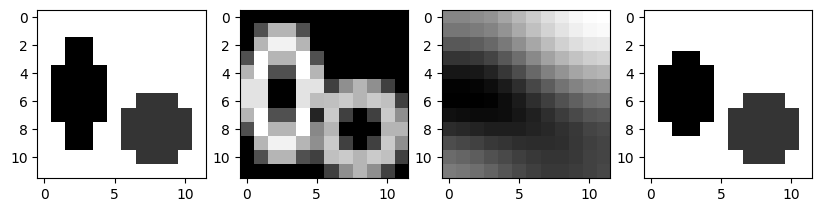

In [34]:
img_org = cv2.imread('/content/small_image_for_test.png')
#img_org = img_org[:, 300:1600]  ## croped image
print('orginal image')
print('img.shape',img_org.shape)
cv2_imshow(img_org)

img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY) 
print('gray image')
print('gray image.shape',img.shape)
cv2_imshow(img)

img2 = img.reshape(-1) ## reshape the image into single column
print('img2.shape',img2.shape)
df = pd.DataFrame()
t0 = time.time()   ## starting time

df['Original Image'] = img2

# # Generate Gabor features
# num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
# kernels = []
# for theta in range(2):   #Define number of thetas
#     theta = theta / 4. * np.pi
#     for sigma in (1, 3):  #Sigma with 1 and 3
#         for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
#             for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
#                 gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
# #                print(gabor_label)
#                 ksize=9
#                 kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
#                 kernels.append(kernel)
#                 #Now filter the image and add values to a new column 
#                 fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
#                 filtered_img = fimg.reshape(-1)
#                 df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
#                 print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
#                 num += 1  #Increment for gabor column label
                
########################################
 #Gerate OTHER FEATURES out of pixels and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe

feat_ext_time = time.time()-t0
local_time_feature_rxtraction = time.localtime(feat_ext_time)

# show some pf the feature images
import matplotlib.pyplot as plots
fig, axes = plots.subplots(1, 4, figsize=(10,10))
print('img.shape',img.shape)
print('img2.shape',img2.shape)

axes[0].imshow(np.asanyarray(df['Original Image']).reshape(img.shape), cmap=plots.cm.gray)
axes[1].imshow(np.asanyarray(df['Sobel']).reshape(img.shape), cmap=plots.cm.gray)
axes[2].imshow(np.asanyarray(df['Gaussian s3']).reshape(img.shape), cmap=plots.cm.gray)
axes[3].imshow(np.asanyarray(df['Median s3']).reshape(img.shape), cmap=plots.cm.gray)

#####################################################
# Threshold the image to obtain binary image
ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)

contours_test, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print('len main contours', len(contours_test))
max_cnt = max(contours_test, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours_test]

# Loop through each contour
for i, cnt in enumerate(contours_test):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours_test, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        #print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 3:
            annotation_test = 1 # (1) Label as a line
        elif aspect_ratio > 1.0 and aspect_ratio < 3:
            annotation_test = 3 # (3) Label as an ellipse 
        else:
            annotation_test = 2 # (2) Label as a circle
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation_test, -1)
        cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour line to be drawn
        

# Combine all masks to create the final annotation image
annotation_test = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation_test[mask > 0] = mask[mask > 0]

# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img_test = np.zeros_like(img_org)

for annotation_value_test, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation_test == annotation_value_test)
  for x,y in pixels_of_certain_type:
    annotated_img_test[x, y] = np.array(color)


# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img_test.shape)
##cv2_imshow(annotated_img)
plt.imsave('/content/test_data_annotated_img.jpg', annotated_img_test) ## see the saved labeled image
##plt.imshow(annotated_img_test)
##plt.axis('off')
##plt.show()

########################
labeled_img1 = annotation_test.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)
print('annotation shape', annotation.shape)

df['Labels'] = labeled_img1
#####################################
print('the unique labels', df['Labels'].unique())
print('the count of the unique labels', df['Labels'].value_counts())

#print("labeled_img1", labeled_img1[88600:88829])
#df.to_csv("before_removing_pixels_pixels_features_and_lables.csv")
# background_filtered = df[df['Labels'] == 0]
# print('background_filtered.shape',background_filtered.shape)
#df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
print('df after remove background',df.shape)
###print(df.head())
df.to_csv("testing_image_pixels_features_and_lables.csv")


Y_test_image = df["Labels"].values
#Define the independent variables
X_test_image = df.drop(labels = ["Labels"], axis=1)


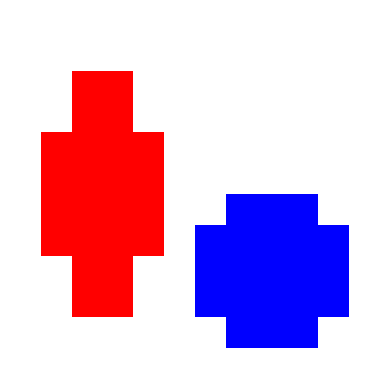

In [35]:
plt.imshow(img_org)
plt.axis('off')
plt.show()

The CLF Random Forest_trained
Accuracy on full image data =  98.611 %
the unique predicted labels [0 1 2 3]
unique predicted Value: 0 Count: 99
unique predicted Value: 1 Count: 2
unique predicted Value: 2 Count: 21
unique predicted Value: 3 Count: 22
img.shape for segmented (12, 12)
img_org.shape for predicted image (12, 12, 3)
annotation_value 1
annotation_value 2
annotation_value 3
predicted_img shape (12, 12, 3)


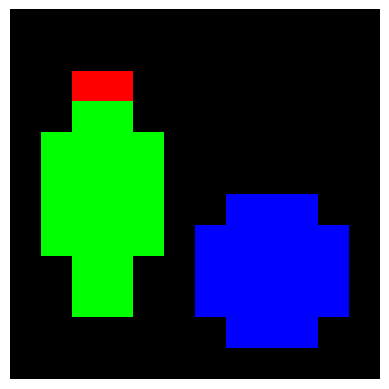

In [36]:
 # extract X from the new image
import os
models_path = "/content/CLF_res"
for model in os.listdir(models_path):  #iterate through each file 
  print('The CLF', model)
  #To test the model on future datasets
  # loaded_model = pickle.load(open(filename, 'rb'))
  if (models_path + '/' + model) != '/content/CLF_res/.ipynb_checkpoints':
    loaded_model = pickle.load(open(models_path + '/' + model, 'rb'))
    prediction_result = loaded_model.predict(X_test_image)

    acc = metrics.accuracy_score(Y_test_image, prediction_result)*100
    print ("Accuracy on full image data = ", round(acc,3), '%')

    unique_values_pred, value_counts_pred = np.unique(prediction_result, return_counts=True)
    print('the unique predicted labels',  unique_values_pred)
    # Display the counts of each unique value
    for value, count in zip(unique_values_pred, value_counts_pred):
        print("unique predicted Value:", value, "Count:", count)

    print('img.shape for segmented',img.shape)
    print('img_org.shape for predicted image',img_org.shape)

    # # Color the pixels belonging to each contour
    colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
    
    segmented = prediction_result.reshape((img.shape))

    predicted_img = np.zeros_like(img_org)

    for annotation_value, color in colors.items():
      print('annotation_value',annotation_value)
      pixels_of_certain_type = np.argwhere(segmented == annotation_value)
      #print('pixels_of_certain_type',pixels_of_certain_type)
      for x,y in pixels_of_certain_type:
        predicted_img[x, y] = np.array(color)

    plt.imshow(predicted_img)
    plt.axis('off')
    #cv2_imshow(predicted_img)
    print('predicted_img shape', predicted_img.shape)
    plt.imsave('/content/predicted_images/predicted_test_image_{}.jpg'.format(model), predicted_img)
    ###################################


# Create a mask to be used as labels (target: three shaps Line,Circle,Ellips)

the orginal image
orginal image shape (12, 12, 3)


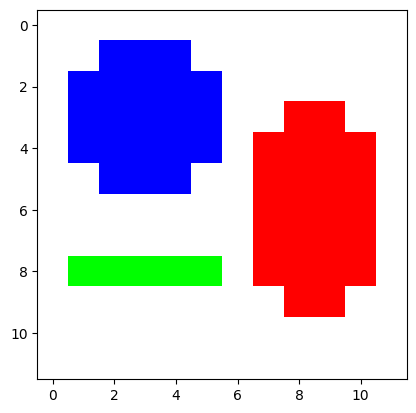

the gray image
gray shape (12, 12)


the binary image
binary shape (12, 12)


len main contours 4
the unique labels [0 1 2 3]
unique Value: 0 Count: 50
unique Value: 1 Count: 16
unique Value: 2 Count: 37
unique Value: 3 Count: 41
the annotated image
annotated_img shape (12, 12, 3)
annotated_img labels: Line=red(255,0,0), Ellipse=Green(0,255,0), Circle=Blue(0,0,255)


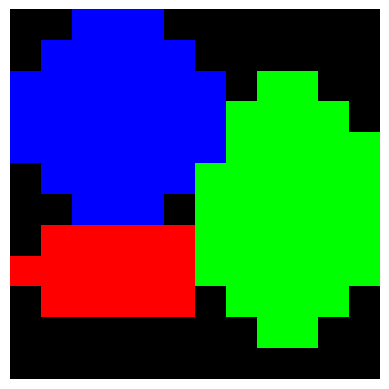

labeled_img1 shape (432,)


In [ ]:
## create a mask with aspect ratio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

# Load the image and convert it to grayscale
img = cv2.imread('/content/small_image.png')
print('the orginal image')
print('orginal image shape', img.shape)
cv2_imshow(img)
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('the gray image')
print('gray shape', gray.shape)
cv2_imshow(gray)
# plt.imshow(gray)
# plt.show()

# Threshold the image to obtain binary image
ret, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)
# plt.imshow(binary)
# plt.show()
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print('len main contours', len(contours))
max_cnt = max(contours, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
#print("masks", masks)

# Loop through each contour
for i, cnt in enumerate(contours):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        #print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 3:
            annotation = 1 # (1) Label as a line
            #cv2.drawContours(img, [cnt], 0, (255, 0, 0), 2)  # red for lines
        elif aspect_ratio > 1 and aspect_ratio < 3:
            annotation = 3 # (3) Label as an ellipse 
            #cv2.drawContours(img, [cnt], 0, (0, 255, 0), 2)  # Green for ellipses
        else:
            annotation = 2 # (2) Label as a circle
            #cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)  # Blue for circles
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation, -1)
        cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour line to be drawn

# Combine all masks to create the final annotation image
annotation = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation[mask > 0] = mask[mask > 0]
#####################
unique_values, value_counts = np.unique(annotation, return_counts=True)
print('the unique labels',  unique_values)
# Display the counts of each unique value
for value, count in zip(unique_values, value_counts):
    print("unique Value:", value, "Count:", count)
#####################
# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img = np.zeros_like(img)

#annotated_img[pix_line[0][0], pix_line[0][1]] = np.array([255, 0, 0])
for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation == annotation_value)
  for x,y in pixels_of_certain_type:
    annotated_img[x, y] = np.array(color)


# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img.shape)
print('annotated_img labels: Line=red(255,0,0), Ellipse=Green(0,255,0), Circle=Blue(0,0,255)')
#cv2_imshow(annotated_img)
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

labeled_img1 = annotated_img.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)


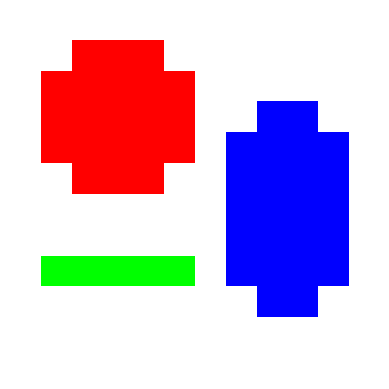

In [ ]:
## the train image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Create a new image with a white background
image = Image.new("RGB", (12, 12), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
circle_radius = 2
circle_center = (3, 3)
circle_color = (255, 0, 0)  # Red
draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
              circle_center[0] + circle_radius, circle_center[1] + circle_radius),
             fill=circle_color, outline=circle_color)

# Draw an ellipse
ellipse_bounds = (7, 3, 10, 9)
ellipse_color = (0, 0, 255)  # Blue
draw.ellipse(ellipse_bounds, fill=ellipse_color, outline=ellipse_color)

# Draw a line
line_start = (1, 8)
line_end = (5, 8)
line_color = (0, 255, 0)  # Green
draw.line((line_start, line_end), fill=line_color, width=1)

# # Draw a line
# line_start = (1, 9)
# line_end = (5, 9)
# line_color = (0, 255, 0)  # Green
# draw.line((line_start, line_end), fill=line_color, width=1)


# Save the image
image.save("small_image.png")

plt.imshow(image)
plt.axis('off')
plt.show()

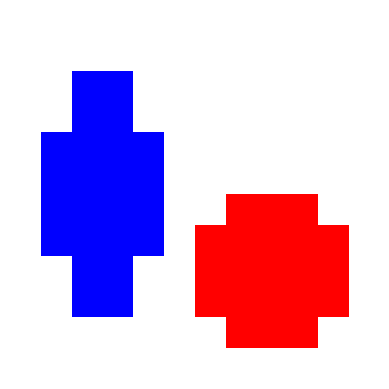

In [ ]:
## the test image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Create a new image with a white background
image = Image.new("RGB", (12, 12), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
circle_radius = 2
circle_center = (8, 8)
circle_color = (255, 0, 0)  # Red
draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
              circle_center[0] + circle_radius, circle_center[1] + circle_radius),
             fill=circle_color, outline=circle_color)

# Draw an ellipse
ellipse_bounds = (1, 2, 4, 9) ## (7, 3, 10, 9)
ellipse_color = (0, 0, 255)  # Blue
draw.ellipse(ellipse_bounds, fill=ellipse_color, outline=ellipse_color)

# # Draw a line
# line_start = (1, 10)
# line_end = (5, 10)
# line_color = (0, 255, 0)  # Green
# draw.line((line_start, line_end), fill=line_color, width=1)


# Save the image
image.save("small_image_for_test.png")

plt.imshow(image)
plt.axis('off')
plt.show()

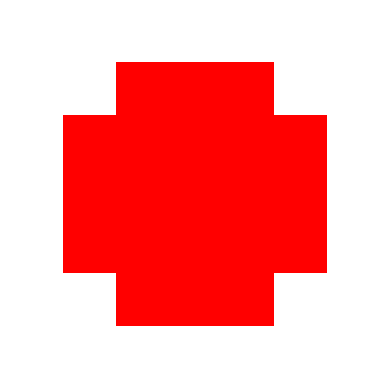

In [ ]:
## the test image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Create a new image with a white background
image = Image.new("RGB", (7, 7), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
circle_radius = 2
circle_center = (3, 3)
circle_color = (255, 0, 0)  # Red
draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
              circle_center[0] + circle_radius, circle_center[1] + circle_radius),
             fill=circle_color, outline=circle_color)

# # Draw an ellipse
# ellipse_bounds = (1, 2, 4, 9) ## (7, 3, 10, 9)
# ellipse_color = (0, 0, 255)  # Blue
# draw.ellipse(ellipse_bounds, fill=ellipse_color, outline=ellipse_color)


# Save the image
image.save("small_image_for_test.png")

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

# Create a 9x9 pixel image
image = np.zeros((5, 5), dtype=np.uint8)

# Generate the x, y values in sequence
x, y = np.meshgrid(range(5), range(5))
xy_values = np.column_stack((x.flatten(), y.flatten()))

# Reshape the xy_values into a single column
reshaped_values = xy_values.reshape((-1))

# Display the xy_values and reshaped_values
print("xy_values:")
print(xy_values)
print("reshaped_values:")
print(reshaped_values)


xy_values:
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]
 [0 3]
 [1 3]
 [2 3]
 [3 3]
 [4 3]
 [0 4]
 [1 4]
 [2 4]
 [3 4]
 [4 4]]
reshaped_values:
[0 0 1 0 2 0 3 0 4 0 0 1 1 1 2 1 3 1 4 1 0 2 1 2 2 2 3 2 4 2 0 3 1 3 2 3 3
 3 4 3 0 4 1 4 2 4 3 4 4 4]


the orginal image
orginal image shape (12, 12, 3)


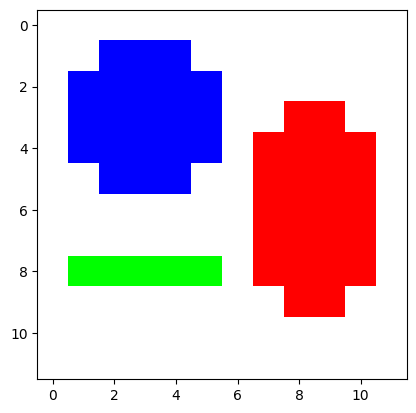

the gray image
gray shape (12, 12)


the binary image
binary shape (12, 12)


len main contours 4
the unique labels [0 1 2 3]
unique Value: 0 Count: 94
unique Value: 1 Count: 5
unique Value: 2 Count: 21
unique Value: 3 Count: 24
the annotated image
annotated_img shape (12, 12, 3)
annotated_img labels: Line=red(255,0,0), Ellipse=Green(0,255,0), Circle=Blue(0,0,255)


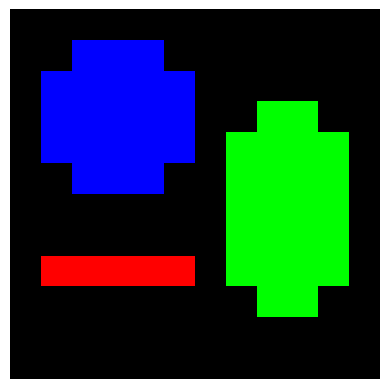

labeled_img1 shape (432,)


In [25]:
### update the labeling with removing the contour borders

## create a mask with aspect ratio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

# Load the image and convert it to grayscale
img = cv2.imread('/content/small_image.png')
print('the orginal image')
print('orginal image shape', img.shape)
cv2_imshow(img)
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('the gray image')
print('gray shape', gray.shape)
cv2_imshow(gray)
# plt.imshow(gray)
# plt.show()

# Threshold the image to obtain binary image
ret, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)
# plt.imshow(binary)
# plt.show()
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# #####################
# cv2.drawContours(img, contours, -1, (255,0,255))
# print('drawcontours')
# plt.imshow(img)
# plt.show()
# #####################
print('len main contours', len(contours))
max_cnt = max(contours, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
#print("masks", masks)

# Loop through each contour
for i, cnt in enumerate(contours):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        #print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 3:
            annotation = 1 # (1) Label as a line
            #cv2.drawContours(img, [cnt], 0, (255, 0, 0), 2)  # red for lines
        elif aspect_ratio > 1 and aspect_ratio < 3:
            annotation = 3 # (3) Label as an ellipse 
            #cv2.drawContours(img, [cnt], 0, (0, 255, 0), 2)  # Green for ellipses
        else:
            annotation = 2 # (2) Label as a circle
            #cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)  # Blue for circles
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation, -1)
        cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour line to be drawn

# Combine all masks to create the final annotation image
annotation = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation[mask > 0] = mask[mask > 0]
#####################
unique_values, value_counts = np.unique(annotation, return_counts=True)
print('the unique labels',  unique_values)
# Display the counts of each unique value
for value, count in zip(unique_values, value_counts):
    print("unique Value:", value, "Count:", count)
#####################
# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img = np.zeros_like(img)

#annotated_img[pix_line[0][0], pix_line[0][1]] = np.array([255, 0, 0])
for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation == annotation_value)
  for x,y in pixels_of_certain_type:
    annotated_img[x, y] = np.array(color)


# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img.shape)
print('annotated_img labels: Line=red(255,0,0), Ellipse=Green(0,255,0), Circle=Blue(0,0,255)')
#cv2_imshow(annotated_img)
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

labeled_img1 = annotated_img.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)
